iter:250 training loss: 0.819166362285614, val loss: 0.6812186241149902
iter:500 training loss: 0.2895818054676056, val loss: 0.2921437621116638
iter:750 training loss: 0.13677220046520233, val loss: 0.17636995017528534
iter:1000 training loss: 0.08550231903791428, val loss: 0.11370162665843964
iter:1250 training loss: 0.06290800869464874, val loss: 0.06435875594615936
iter:1500 training loss: 0.05142547935247421, val loss: 0.04761706665158272
iter:1750 training loss: 0.040518466383218765, val loss: 0.0399567149579525
iter:2000 training loss: 0.03481724485754967, val loss: 0.0395653061568737
iter:2250 training loss: 0.03002830222249031, val loss: 0.03174610808491707
iter:2500 training loss: 0.023950494825839996, val loss: 0.028199519962072372
iter:2750 training loss: 0.01979190669953823, val loss: 0.0221108365803957
iter:3000 training loss: 0.017769241705536842, val loss: 0.020458247512578964
iter:3250 training loss: 0.015734324231743813, val loss: 0.014105752110481262
iter:3500 traini

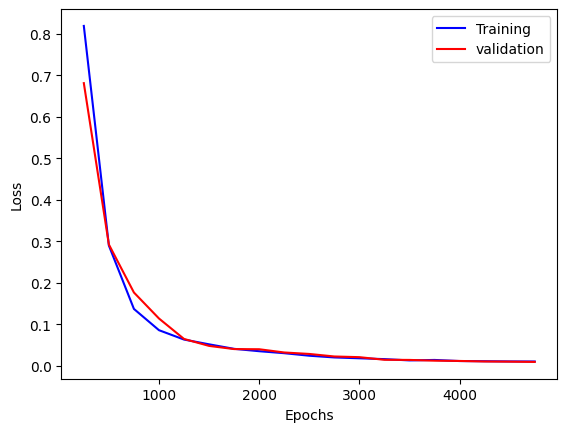

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px


def visualise_tensor(data):
    data = data.detach().numpy()

    ## Create colormap (red to blue)
    colormap = 'RdBu_r'
    # Plot the matrix
    fig = px.imshow(data, color_continuous_scale=colormap, zmin=-1, zmax=1)
    fig.show()
    fig.data = ()

input_size = 5
hidden_layer_size= 2
output_size = input_size
learning_rate = 0.01
max_iters = 5000
dataset_size = 1024
sparsity = 0.1 # appears only one in 100 times
batch_size = 32

decay_factor = 0.9
iters = []
loss_value = []
val_loss_value = []

imp_vector =torch.tensor([0.7**i for i in range(input_size)])


def get_l1_penalty():
    l1_penalty = 0
    for param in model.parameters():
        if param.requires_grad:
            l1_penalty += torch.norm(param, p=1)
    return l1_penalty

def sample_data():
    # TODO Implement mini batch
    a,b = training_dataset.shape
    sparsity_mat = torch.bernoulli(torch.full((a,b), sparsity))
    X = training_dataset*sparsity_mat
    return X, X

def sample_validation_data():
    a,b = validation_dataset.shape
    sparsity_mat = torch.bernoulli(torch.full((a,b), sparsity))
    X = validation_dataset*sparsity_mat
    return X, X


def get_loss(target, output):
    loss = (imp_vector*((target-output)**2)).mean()
    return loss


import torch.nn as nn
import torch

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Create weight parameters in log space
        self.log_weight1 = nn.Parameter(torch.randn(input_size, hidden_layer_size))
        self.log_weight2 = nn.Parameter(torch.randn(hidden_layer_size, output_size))
        
        # bias for layer2 since layer1 is bias=False
        self.bias2 = nn.Parameter(torch.zeros(output_size))
        self.relu = nn.ReLU()
    
    def forward(self, input, targets=None):
         # Input is (B,I)
        
        # Exponentiate the log_weights to get actual weights
        weight1 = self.log_weight1.exp()
        weight1_t = torch.transpose(weight1, 0,1)
        weight2 = self.log_weight2.exp()


        # Manual matrix multiplication with positive weights
        logits = input @ weight1  # (B, dim)
        logits = logits @ weight1_t + self.bias2  # (B, output_size)
        # logits = self.relu(logits)  # activation

        if targets is None:
            return logits
        else:
            loss = get_loss(targets, logits)
            return logits, loss


training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model()

LOAD_MODEL = False
PATH = "models/basic_relu_0.10.bin"
if LOAD_MODEL:
    model = Model()
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X, Y = sample_data()
        logits, loss = model(X, Y)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V,Y_V = sample_validation_data()
                _, val_loss = model(X_V, Y_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        #loss+= get_l1_penalty()
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()
    plt.show()




In [64]:


w1 = model.log_weight1.exp()
w2 = torch.transpose(w1, 0, 1)

b2 = model.bias2
# visualise_tensor(torch.transpose(w1,0,1)@w1)
visualise_tensor(w1)
visualise_tensor(w2)
visualise_tensor(w1@w2)
visualise_tensor(b2.data.reshape(-1,1))

In [56]:
# Norm of embedding
w1 = w2
norm = [0 for i in range(input_size)]
for i in range(input_size):
    idx = torch.zeros(input_size)
    idx[i] = 1
    idx = w1@idx
    norm[i] = idx.norm()
norm = torch.tensor(norm)
visualise_tensor(norm.reshape(-1,1))


# Interference
dot = [0 for i in range(input_size)]
for i in range(input_size):
    s = 0
    embed_a = w1[:,i]
    for j in range(input_size):
        if i==j:
            continue
        embed_b = w1[:,j]
        s+= (torch.dot(embed_a,embed_b))**2
    
    dot[i] = s

dot = torch.tensor(dot)
print(dot)
visualise_tensor(dot.reshape(-1,1))


tensor([9.3303e-07, 9.4558e-07, 1.2606e-05, 6.6425e-04, 1.1848e-03, 6.7209e-04,
        1.1203e-03, 6.4978e-05, 3.4949e-06, 8.3052e-07, 1.0945e-07, 2.5091e-07,
        2.4077e-07, 1.2812e-07, 1.0239e-07, 1.2893e-07, 1.1401e-07, 1.2750e-07,
        1.0101e-07, 1.1246e-07])
